In [1]:
import json
BLANK_DATA_FILE = "./Data/JSON/BlankData.json"

def GetData():
    with open(BLANK_DATA_FILE) as fp:
        data = json.load(fp)
    return data

In [2]:
# 制作索引
def GetIndex(data):
    index = {}
    for val in data:
        index[(int(val['songid']), val['id'])] = val
    return index

In [3]:
def CheckBlankExist(index, musicId, blankId):
    return index.get((musicId, blankId)) is not None

In [4]:
def GetLength(index, songId, blankId):
    if not CheckBlankExist(index, songId, blankId):
        # 第一段的前一段和最后一段的后一段长度视为 1 (反正就是很短)
        return 1
    else:
        starttime = index[(songId, blankId)]['starttime']
        endtime   = index[(songId, blankId)]['endtime']
        return max(endtime - starttime, 0)

In [5]:
def GetEnd(index, songId, blankId):
    if not CheckBlankExist(index, songId, blankId):
        # 第一段的前一段和最后一段的后一段长度视为 1 (反正就是很短)
        return 1
    else:
        # starttime = index[(songId, blankId)]['starttime']
        endtime   = index[(songId, blankId)]['endtime']
        return endtime

In [6]:
# 计算歌曲总长度
MUSIC_LENGTH_CACHE = {}
def GetTotalTimeForSong(index, songId):
    global MUSIC_LENGTH_CACHE

    # 未在缓存中，重新计算音乐总长度
    if MUSIC_LENGTH_CACHE.get(songId) is None:
        blankId = 0
        ans = 0
        while CheckBlankExist(index,songId, blankId):
            ans     = max(ans, GetEnd(index, songId, blankId))
            blankId += 1
        MUSIC_LENGTH_CACHE[songId] = ans
        assert ans > 0, "ERROR WHEN CALCULATE THE LENGTH OF SONG_ID: %d" % songId
    
    return MUSIC_LENGTH_CACHE[songId]

In [7]:
def GetFeatures(index, val):
    songId  = int(val['songid'])
    blankId = val['id']

    import math
    # 片段长度用对数长度衡量

    totalTime = GetTotalTimeForSong(index, songId)
    
    lastLen  = math.log(GetLength(index, songId, blankId - 1))
    beginPos = val['starttime'] / totalTime
    nowLen   = math.log(GetLength(index, songId, blankId + 0))
    endnPos = val['endtime'] / totalTime
    nextLen  = math.log(GetLength(index, songId, blankId + 1))

    isShort = (GetLength(index, songId, blankId + 0) < 100)
    return [lastLen, beginPos, nowLen, endnPos, nextLen], isShort

In [8]:
def GetDataXy(data, deleteEnd = True, SelectAll = True, musicIdMin = 3, musicIdMax = 26):
    X_all = []
    y_all = []

    # 制作索引
    index = GetIndex(data)

    for musicId in range(musicIdMin, musicIdMax + 1):
        blankId = 0
        while CheckBlankExist(index, musicId, blankId):
            val = index[(musicId, blankId)]
            blankId += 1

            # 不要将最后一列加入到训练集合中
            if not deleteEnd or CheckBlankExist(index, musicId, blankId):
                x_now, isShort = GetFeatures(index, val)
                if not isShort or SelectAll:
                    X_all.append(x_now)
                    y_all.append(val['cut'])

    import numpy as np
    return np.array(X_all), np.array(y_all)

In [9]:
C_VALUE = 30
GAMMA_VALUE = 0.25

def GetSvm():
    data = GetData()
    X, y = GetDataXy(data, deleteEnd = True)

    # 归一化
    from sklearn.preprocessing import StandardScaler
    std = StandardScaler().fit(X)
    X = std.transform(X)

    from sklearn.svm import SVC
    svm = SVC(kernel='rbf', C=C_VALUE, gamma=GAMMA_VALUE, probability=True).fit(X, y)

    return svm, std

In [10]:
def ShowConfusionMatrix():
    data = GetData()
    X, y = GetDataXy(data, deleteEnd = True)

    from sklearn.svm import SVC
    svm = SVC(kernel='rbf', C=C_VALUE, gamma=GAMMA_VALUE, probability=True).fit(X, y)

    y_true = y
    y_pred = svm.predict(X)

    from sklearn.metrics import confusion_matrix
    cm = confusion_matrix(y_true, y_pred) / len(X)

    import seaborn as sns
    from matplotlib import pyplot as plt
    sns.heatmap(data=cm, annot=True, fmt="f", cmap="RdBu_r")
    plt.show()

In [11]:
def GetSolveName(songid: str):
    if type(songid) == int:
        songid = "%04d" % songid

    assert len(songid) == 4
    return "./Data/SOLVE/%s.solve.json" % songid

In [12]:
import math
def GetSongFeatureBySongId(songId):
    solveFileName = GetSolveName(songId)

    with open(solveFileName) as fp:
        solveData = json.load(fp)

    totalTime = 0
    X = []
    for blank in solveData:
        totalTime = max(totalTime, blank['endtime'])

        beginPos = blank['starttime']
        nowLen   = math.log(max(blank['endtime'] - blank['starttime'], 1))
        endPos = blank['endtime']

        dataNow = [ 0, beginPos, nowLen, endPos, 0] # beginPos 和 endPos 需要后期缩放
        X.append(dataNow) # lastLen， nextLen 需要一会填充

    assert totalTime > 0

    for i in range(len(X)):
        X[i][0] = 0 if i == len(X) - 1 else X[i+1][2]
        X[i][1] /= totalTime
        X[i][3] /= totalTime
        X[i][4] = 0 if i == 0 else X[i-1][2]

    import numpy as np
    return np.array(X)


In [13]:
def GetSongBlanksBySongId(songId):
    solveFileName = GetSolveName(songId)

    with open(solveFileName) as fp:
        solveData = json.load(fp)
    
    return solveData

In [14]:
def GetTimeFromPos(pos):
    pos = int(pos + 0.5)
    
    minute = pos // 60
    second = pos % 60

    return "%02d:%02d" % (minute, second)

In [15]:
def FitSong(songId: int, isShow = True, BEST_CNT = 5):

    if isShow:
        print("FIT SONG %d ..." % songId)

    svm, std = GetSvm()

    X = std.transform(GetSongFeatureBySongId(songId))
    blanks = GetSongBlanksBySongId(songId)

    # 预测是否在右端点处分段
    y = svm.predict_proba(X)
    assert len(y) == len(blanks)

    # 二分法保证短 BEST_CNT 次
    LEFT     = 0.1
    RIGHT    = 0.9
    EPS      = 0.001
    while (RIGHT - LEFT) > EPS:
        exist = {}
        MID_VALUE = (LEFT + RIGHT) / 2
        for i in range(len(y)):
            if y[i][1] >= MID_VALUE:
                pos = max(blanks[i]['endtime'] / 200, 0)
                tnow = GetTimeFromPos(pos)
                exist[tnow] = True

        cnt = len(exist)
        if cnt < BEST_CNT:
            RIGHT = MID_VALUE
        elif cnt == BEST_CNT:
            break
        else:
            LEFT = MID_VALUE
    
    exist = {}
    MID_VALUE = (LEFT + RIGHT) / 2

    outputStr = ""

    for i in range(len(y)):
        if y[i][1] > MID_VALUE:
            pos = max(blanks[i]['endtime'] / 200, 0)
            tnow = GetTimeFromPos(pos)
            if exist.get(tnow) is None:
                outputStr += tnow + "\n"
                exist[tnow] = True

    if isShow:
        print(outputStr)
        print("DONE.\n")

    return outputStr

In [16]:
FitSong(25)

FIT SONG 25 ...
00:03
00:47
01:07
01:30
01:51

DONE.



'00:03\n00:47\n01:07\n01:30\n01:51\n'

In [17]:
N = 39
for i in range(3, N + 1):
    FitSong(i)

FIT SONG 3 ...
00:06
00:16
00:17
00:29
00:32

DONE.

FIT SONG 4 ...
00:03
00:16
01:01
01:15
01:28

DONE.

FIT SONG 5 ...
00:11
00:36
01:29
02:51
03:07

DONE.

FIT SONG 6 ...
00:09
00:45
00:50
01:12
01:43

DONE.

FIT SONG 7 ...
00:08
01:30
01:58
02:35
02:50

DONE.

FIT SONG 8 ...
00:08
00:36
01:30
02:25
04:00

DONE.

FIT SONG 9 ...
00:04
00:58
01:31
01:34
03:42

DONE.

FIT SONG 10 ...
00:07
00:48
02:00
02:52
03:00

DONE.

FIT SONG 11 ...
00:12
01:34
01:47
02:11
04:16

DONE.

FIT SONG 12 ...
00:15
00:19
00:20
01:01
01:16

DONE.

FIT SONG 13 ...
00:08
01:26
02:39
02:56
03:00

DONE.

FIT SONG 14 ...
00:03
00:24
00:25
00:52
01:31

DONE.

FIT SONG 15 ...
00:03
00:34
00:35
03:53
03:59

DONE.

FIT SONG 16 ...
00:11
00:19
00:22
00:42
02:41

DONE.

FIT SONG 17 ...
00:00
01:14
01:26
01:43
02:25

DONE.

FIT SONG 18 ...
00:03
01:29
01:34
02:45
04:06

DONE.

FIT SONG 19 ...
00:03
00:15
00:37
01:41
02:15

DONE.

FIT SONG 20 ...
00:03
02:20
02:23
03:04
03:27

DONE.

FIT SONG 21 ...
00:12
00:47
01:23
0

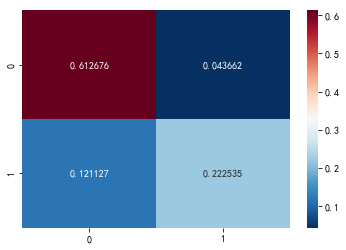

In [22]:
ShowConfusionMatrix()

In [19]:
def GetTimeDis(T1, T2):
    m1, s1 = map(int, T1.split(":"))
    m2, s2 = map(int, T2.split(":"))

    return (m1 - m2) * 60 + (s1 - s2)

In [20]:
def Evaluate(songId):
    manFile = "./Data/MAN/%04d.man" % songId
    manSeq = open(manFile, "r").read().split('\n')

    timeSeq = FitSong(songId, False).split('\n')

    delta = 0
    cnt   = 0
    for timeMachine in timeSeq:

        if timeMachine == '':
            continue
        else:
            cnt += 1

        minDis = 1e9
        for timeMan in manSeq:
            if timeMan == '':
                continue
            minDis = min(minDis, abs(GetTimeDis(timeMachine, timeMan)))

        delta += minDis

    return delta/cnt, delta

In [21]:
for i in range(3, 39 + 1):
    aveD, sumD = Evaluate(i)
    print("%04d: %6.1lf, %6.1lf" % (i, aveD, sumD))

0003:    4.0,   20.0
0004:   11.6,   58.0
0005:    3.8,   19.0
0006:   13.4,   67.0
0007:    4.6,   23.0
0008:   16.6,   83.0
0009:   15.2,   76.0
0010:   16.4,   82.0
0011:    6.6,   33.0
0012:    2.0,   10.0
0013:    5.0,   25.0
0014:    6.0,   30.0
0015:   10.6,   53.0
0016:    7.4,   37.0
0017:    3.8,   19.0
0018:    4.0,   20.0
0019:    3.8,   19.0
0020:   10.2,   51.0
0021:   18.4,   92.0
0022:    6.8,   34.0
0023:   10.4,   52.0
0024:    8.4,   42.0
0025:    5.2,   26.0
0026:    6.8,   34.0
0027:    4.0,   20.0
0028:    7.0,   35.0
0029:    2.6,   13.0
0030:    6.0,   30.0
0031:    8.6,   43.0
0032:   10.4,   52.0
0033:    3.0,   12.0
0034:    7.6,   38.0
0035:    2.2,   11.0
0036:    9.4,   47.0
0037:    7.0,   35.0
0038:   14.0,   70.0
0039:    2.2,   11.0
